In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('gurgaon_properties_post_feature_selection_v2.csv')

In [3]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [4]:
#all categorical columns are back..
#we have earlier tranformed into numbers.. but we'll later apply all
#transformation in pipeline

In [5]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
1.0    1018
2.0     187
Name: count, dtype: int64

In [6]:
#furnishing_type is in numvers, so we'll convert them to
#categories again manually

In [7]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [8]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [9]:
X = df.drop(columns=['price'])
y = df['price']

In [10]:
#since price column is right skewed
#so we'll apply log transformation
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

### We'll be using 3 types of encoding, Train models & Compare r2_score
### whichever gives highest score, we'll keep that:

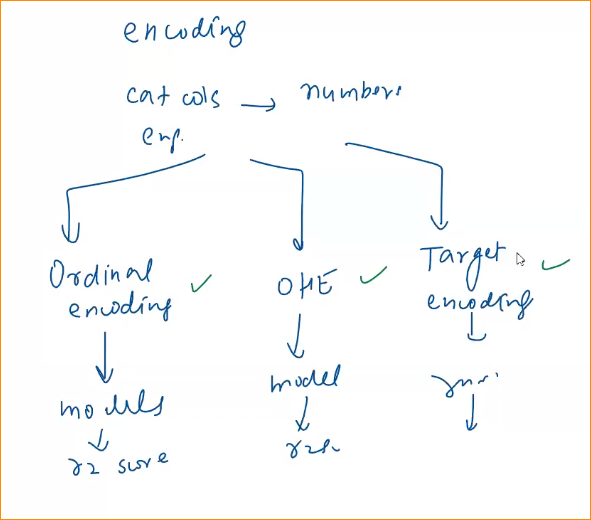

In [11]:



# ohe works well with linear models
# target encoding works well with tree based models, whereever you have high dimensionality features



### ordinal encoding

##### ordinal encoding works well with tree based model bcoz of no concept of order, it will asign int values to each categpry
##### but when using linear models for predictions, it will give more weightage to higher integer & will not give good predictions
##### it will have no effect on tree based models

In [12]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [13]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ], 
    remainder='passthrough'
)

In [14]:
# creating a pipeline where above transformation will be applied
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])

In [15]:
# also perform cross validation
# also perform cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [16]:
scores.mean(), scores.std()

(0.7363096633436828, 0.0323800575442993)

In [17]:
#reults are not so good, bcoz ordinal encoding will misguide linear models
#still its too bad, std is still less

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size = 0.2, random_state=42)

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [20]:
y_pred = pipeline.predict(X_test)

In [21]:
y_pred = np.expm1(y_pred)

In [22]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.946382216008937

In [23]:
#currently MAE is 0.94 means mistake of 94 lakhs 
#if a property is 2crore, model will predict 3crore or 1 crore
#which is clearly not good

In [24]:
#converting above flow in a function
#we just need to pass model name & it will return r2 score & MAE

def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output    

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

model_dict = {
    'linear_reg': LinearRegression(),
    'svr': SVR(),
    'ridge': Ridge(),
    'LASSO': Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest': RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost': XGBRegressor()
}

In [26]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [27]:
model_output

[['linear_reg', 0.7363096633436828, 0.946382216008937],
 ['svr', 0.7642012011196353, 0.8472636473483927],
 ['ridge', 0.7363125343993551, 0.9463387741853372],
 ['LASSO', 0.05943378064493572, 1.528905986892753],
 ['decision tree', 0.7763313498333144, 0.732045468428268],
 ['random forest', 0.8814746823621589, 0.5339390543104049],
 ['extra trees', 0.8684392620500535, 0.5519052405029822],
 ['gradient boosting', 0.8725529631949946, 0.5757610630985528],
 ['adaboost', 0.7549533640816467, 0.8411803245839329],
 ['mlp', 0.8149091476001432, 0.7013541199576621],
 ['xgboost', 0.8894876835260124, 0.5040475141482346]]

In [28]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [29]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.881475,0.533939
6,extra trees,0.868439,0.551905
7,gradient boosting,0.872553,0.575761
9,mlp,0.814909,0.701354
4,decision tree,0.776331,0.732045
8,adaboost,0.754953,0.841180
1,svr,0.764201,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382


In [30]:
#unsurprisingly xgboost is giving least MAE & highest r2 score
#all tree based algorithms are also performing good
#mlp is a deep learning model
#all linear models are not performing good since we are using ordinal encoding

### One Hot Encoding

- In ordinal encoding, if we are applying it on property_type it will asign 0,1,2 which basically
  means that an order has been induced automatically & linear models are giving weightage according to those
  orders & thats why they are not performing good unlike tree based models which doesnt get effected by 
  orders
  
- In OHE, instead of asigning int values, we'll create 3 new columns & asign vector values like 011, 010, 001 etc
  which will not induce any order & we can drop one of the column to remove multi colinearity.
  
- so we'll apply OHE on all those categorical column where there is no order

- THere's 1 issue with OHE & thats training will be slower due to multi dimensionality

In [31]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession','furnishing_type'])
    ], 
    remainder='passthrough'
)

In [32]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [33]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [34]:
scores.mean()

0.854614555283803

In [35]:
scores.std()

0.015994832501687685

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [37]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [38]:
y_pred = pipeline.predict(X_test)

In [39]:
y_pred = np.expm1(y_pred)

In [40]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.6497654068103245

In [41]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [42]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [43]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

C:\Users\iampr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [45]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.894233,0.471610
10,xgboost,0.895850,0.493456
5,random forest,0.890652,0.496796
9,mlp,0.871767,0.515447
7,gradient boosting,0.876518,0.568606
0,linear_reg,0.854615,0.649765
2,ridge,0.854691,0.652915
4,decision tree,0.803566,0.696181
8,adaboost,0.757238,0.824823
1,svr,0.769741,0.834124


In [46]:
#ohe improves the score but since its a small dataset, it will easily train 
#whereas with big data, it will take longer to train so what can we do?
#we still need to apply OHE, we can perform dimensionality reduction & apply technique like PCA, t-SNE, LDA etc

### OneHotEncoding With PCA

In [47]:
#with PCA, we keep only those columns which explains atleast 95% variance
#when we say we keep only those columns that explain at least 95% variance with PCA, we're essentially
#selecting the most important features that capture the essence of the data while discarding less important
#and potentially redundant information. This helps in creating a more manageable and efficient representation
#of the dataset for machine learning purposes.

In [48]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ], 
    remainder='passthrough'
)

In [49]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [50]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [51]:
scores.mean()

0.06225201431451137

In [52]:
scores.std()

0.019860594071640186

In [53]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [54]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [55]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [56]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [57]:
model_df.sort_values(['mae'])

,name,r2,mae
5,random forest,0.762074,0.665325
6,extra trees,0.739651,0.695559
4,decision tree,0.696182,0.757290
10,xgboost,0.620664,0.948597
7,gradient boosting,0.610604,0.987906
8,adaboost,0.310247,1.325915
1,svr,0.218073,1.361163
9,mlp,0.205856,1.401152
2,ridge,0.062252,1.526707
0,linear_reg,0.062252,1.526707


In [58]:
#this performed very bad, results are drastically down 

### Target Encoding

- Its mostly used on columns with high cardinality or dimensionality like sector in our data, there are around 100 categories

- In target encoding, we decide a values on the basis of target.. we'll replace the value in sector with mean of thier prices

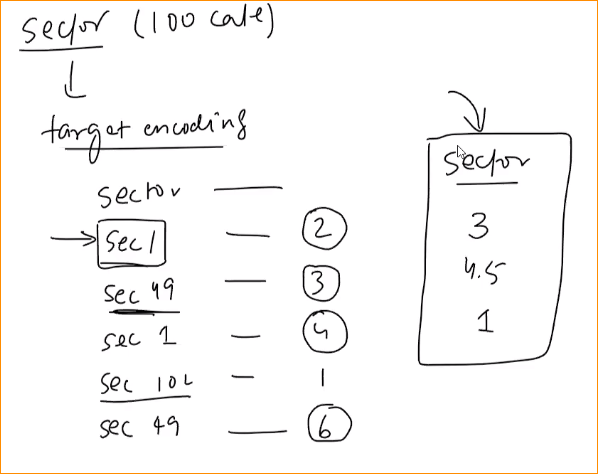

In [59]:
#whenever doing target encoding, be very cautious bcoz data leakage will occur
#so always perform train, test, split before target encoding

In [60]:
# !pip uninstall category_encoders

In [61]:
!pip install category_encoders

In [62]:
import category_encoders as ce

columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [63]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [64]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [65]:
scores.mean(),scores.std()

(0.829521918225536, 0.018384463379122935)

In [66]:
#target encoding give good results on tree based algorithms but not on linear algorithms
#results on linear models will be better what you get with ordinal encoding

In [67]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [68]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [69]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [70]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [71]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.904798,0.447518
5,random forest,0.901045,0.461788
6,extra trees,0.903047,0.464428
7,gradient boosting,0.888949,0.510847
4,decision tree,0.827473,0.567669
9,mlp,0.849902,0.616839
8,adaboost,0.816603,0.697119
0,linear_reg,0.829522,0.713011
2,ridge,0.829536,0.713523
1,svr,0.782917,0.818851


In [72]:
#we're getting best result uptill yet & thats on random forest with 90% accuracy & MAE 45lakhs
#since we've to do model selection, so xgboost & random forest are giving best results
#by performing target encoding on sector col
#now we've to do hyper parameter tuning using this setup
#bcoz until yet we were using default settings
#specially with xgboost & baysian hyper parameter tuning: hyoper opt
#this combination does best hyper parameter tuning, lot of people use this on kaggle competition

### Hyper parameter tuning

(on random forest)

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [104]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ], 
    remainder='passthrough'
)

In [105]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [106]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [107]:
search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [108]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


C:\Users\iampr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\iampr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\iampr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\iampr\AppData\Local\Programs\Python\Python310\lib\site-pac

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['property_type',
                                                                          'sector',
                                                                          'balcony',
                                                                          'agePossession',
                                                                          'furnishing_type',...
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['agePossession']),
                                                                        ('target_enc',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [109]:
final_pipe = search.best_estimator_

In [110]:
search.best_params_

{'regressor__max_depth': 30,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 100}

In [111]:
search.best_score_

0.9029489340403133

In [112]:
final_pipe.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       max_samples=1.0))])

### Exporting the model

In [113]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
    ], 
    remainder='passthrough'
)

In [114]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500))
])

In [115]:
pipeline.fit(X,y_transformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sector',
                                                   'agePossession'])])),
                ('regressor', RandomForestRegressor(n_estimators=500))])

In [116]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [117]:
with open('df.pkl', 'wb') as file:
    pickle.dump(X, file)

In [118]:
X

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...
3549,flat,sector 84,2.0,2.0,1,Relatively New,532.0,0.0,0.0,unfurnished,Medium,Mid Floor
3550,house,sector 109,5.0,5.0,3+,Relatively New,6228.0,1.0,1.0,unfurnished,High,Low Floor
3551,flat,sector 2,1.0,1.0,1,Moderately Old,665.0,0.0,0.0,semifurnished,Medium,Mid Floor
3552,house,sector 43,5.0,6.0,3,Moderately Old,5490.0,1.0,1.0,unfurnished,Medium,Mid Floor


### Trying out the predictions

In [119]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')

In [120]:
X.iloc[0].values

array(['flat', 'sector 36', 3.0, 2.0, '2', 'New Property', 850.0, 0.0,
       0.0, 'unfurnished', 'Low', 'Low Floor'], dtype=object)

In [121]:
data = [['house', 'sector 102', 4, 3, '3+', 'New Property', 2750, 0, 0, 'unfurnished', 'Low', 'Low Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category']

# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df


,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,house,sector 102,4,3,3+,New Property,2750,0,0,unfurnished,Low,Low Floor


In [122]:
np.expm1(pipeline.predict(one_df))

array([3.19011382])

In [123]:
X.dtypes

property_type       object
sector              object
bedRoom            float64
bathroom           float64
balcony             object
agePossession       object
built_up_area      float64
servant room       float64
store room         float64
furnishing_type     object
luxury_category     object
floor_category      object
dtype: object

In [124]:
sorted(X['sector'].unique().tolist())

['dwarka expressway',
 'gwal pahari',
 'manesar',
 'sector 1',
 'sector 10',
 'sector 102',
 'sector 103',
 'sector 104',
 'sector 105',
 'sector 106',
 'sector 107',
 'sector 108',
 'sector 109',
 'sector 11',
 'sector 110',
 'sector 111',
 'sector 112',
 'sector 113',
 'sector 12',
 'sector 13',
 'sector 14',
 'sector 15',
 'sector 17',
 'sector 2',
 'sector 21',
 'sector 22',
 'sector 23',
 'sector 24',
 'sector 25',
 'sector 26',
 'sector 27',
 'sector 28',
 'sector 3',
 'sector 30',
 'sector 31',
 'sector 33',
 'sector 36',
 'sector 37',
 'sector 37d',
 'sector 38',
 'sector 39',
 'sector 4',
 'sector 40',
 'sector 41',
 'sector 43',
 'sector 45',
 'sector 46',
 'sector 47',
 'sector 48',
 'sector 49',
 'sector 5',
 'sector 50',
 'sector 51',
 'sector 52',
 'sector 53',
 'sector 54',
 'sector 55',
 'sector 56',
 'sector 57',
 'sector 58',
 'sector 59',
 'sector 6',
 'sector 60',
 'sector 61',
 'sector 62',
 'sector 63',
 'sector 63a',
 'sector 65',
 'sector 66',
 'sector 67',
 'se

## Tips to improve the accuracy

1. Bring more data
2. Do better hyper parameter tuning on RF
3. Apply Xgboost & baysean setup

In [125]:
one_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   property_type    1 non-null      object
 1   sector           1 non-null      object
 2   bedRoom          1 non-null      int64 
 3   bathroom         1 non-null      int64 
 4   balcony          1 non-null      object
 5   agePossession    1 non-null      object
 6   built_up_area    1 non-null      int64 
 7   servant room     1 non-null      int64 
 8   store room       1 non-null      int64 
 9   furnishing_type  1 non-null      object
 10  luxury_category  1 non-null      object
 11  floor_category   1 non-null      object
dtypes: int64(5), object(7)
memory usage: 224.0+ bytes
